In [3]:
%matplotlib inline

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

 ______________________________________________
# Multi genre Classification
## echonest audio features
 _______________________________________________

# 1. Preprocessing

In [5]:
echo_genres = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.drop('listens', axis=1, inplace=True)
echo_genres.drop('comments', axis=1, inplace=True)

echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,168,256
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,237,256
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,206,256
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,161,192
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,207,256


In [6]:
# remove duplicates
print(f"shape before removing duplicates {echo_genres.shape}")
echo_genres.drop_duplicates(keep=False, inplace=True)
print(f"shape after removing duplicates {echo_genres.shape}")

shape before removing duplicates (13129, 11)
shape after removing duplicates (13129, 11)


In [7]:
echo_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

In [8]:
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']
# generating dataset for multiclass classification task
echo_gen = echo_genres[echo_genres['genre_top'].isin(genres_subset)]
echo_gen.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,168,256
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,237,256
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,206,256
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,161,192
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,207,256


In [9]:
echo_gen.shape

(9055, 11)

In [10]:
pd.concat([echo_gen.genre_top.value_counts(),
                round(echo_gen.genre_top.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,3892,42.98
Electronic,2170,23.96
Hip-Hop,910,10.05
Folk,874,9.65
Old-Time / Historic,357,3.94
Pop,346,3.82
Classical,265,2.93
Jazz,241,2.66


In [11]:
# encoding labels
le = preprocessing.LabelEncoder()
echo_gen['genre_top'] = le.fit_transform(echo_gen['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
echo_gen.genre_top.value_counts()

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


7    3892
1    2170
3     910
2     874
5     357
6     346
0     265
4     241
Name: genre_top, dtype: int64

In [12]:
# detach target col
labels = echo_gen[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [13]:
echo_gen.drop('genre_top', axis=1, inplace=True)

In [14]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(echo_gen)

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot

Text(0.5, 0, 'Principal Component #')

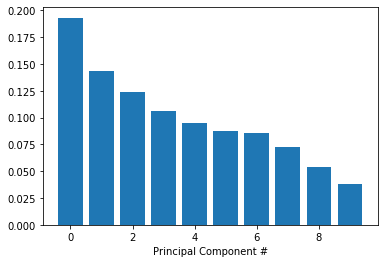

In [15]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

Optimal number of components: 7
Explained variation per principal component:
[0.19325688 0.14314379 0.12424739 0.10632678 0.09512723 0.08768432
 0.08543204]


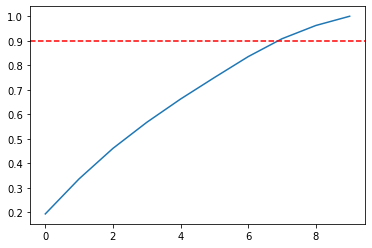

In [17]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--',c='r')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)


## 2.2 Plot PCA in 2D

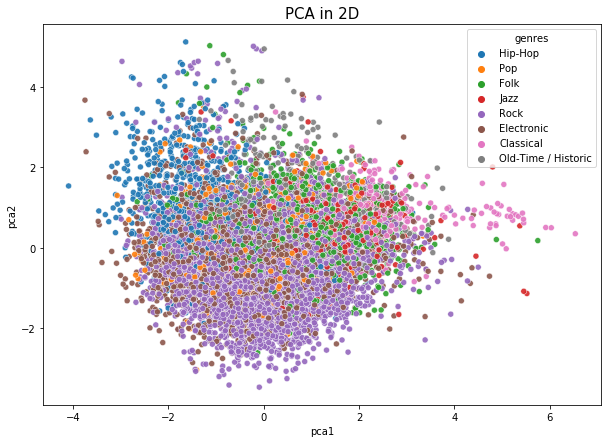

In [18]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

Rock, Classic and Hip-Hop are well separated from the others.
Jazz instead, is very close to classical (probably due to instrumentality of the two genres), in fact
is located on the leftmost side of the graph.

### 2.3 Plot PCA in 3D

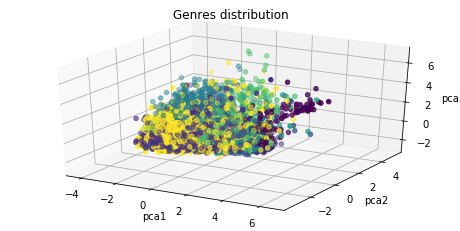

In [21]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection = '3d')

x = df['pca1']
y = df['pca2']
z = df['pca3']
c = labels

ax.set_xlabel("pca1")
ax.set_ylabel("pca2")
ax.set_zlabel("pca3")

scatter = ax.scatter(x, y, z, c=c)
ax.set_title('Genres distribution')
plt.show()
 


# 3. Split data for classification

In [22]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(                 #not normalized
echo_gen, labels, test_size=0.30, random_state=10)

In [23]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

***PCA***
Development set:
7    2730
1    1535
3     644
2     591
5     244
6     235
0     184
4     175
Name: genre_top, dtype: int64

Internal Test:
7    1162
1     635
2     283
3     266
5     113
6     111
0      81
4      66
Name: genre_top, dtype: int64

\-----------------
\***No-PCA***
Development set:
7    2730
1    1535
3     644
2     591
5     244
6     235
0     184
4     175
Name: genre_top, dtype: int64

Internal Test:
7    1162
1     635
2     283
3     266
5     113
6     111
0      81
4      66
Name: genre_top, dtype: int64


# 4. Decision Tree
### a) Unbalanced - without PCA
#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [34]:
# search parameters
param_grid = {
               "max_depth": [3,4,5,7,8,10],
               "min_samples_leaf": [10,15,25,35,55,75],
               "min_samples_split":[5,10,20,30],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best parameters:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 30}
accuracy: 0.6292197719842945
Model with rank: 1
Mean validation score: 0.629 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 30}

Model with rank: 2
Mean validation score: 0.629 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.629 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.629 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 20}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [24]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=7, min_samples_leaf= 10, min_samples_split=30)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.6198012513801987
F1-score [0.64444444 0.59224806 0.3984375  0.57620042 0.21487603 0.760181
 0.03448276 0.71968191]
              precision    recall  f1-score   support

           0       0.59      0.72      0.64        81
           1       0.58      0.60      0.59       635
           2       0.45      0.36      0.40       283
           3       0.65      0.52      0.58       266
           4       0.24      0.20      0.21        66
           5       0.78      0.74      0.76       113
           6       0.40      0.02      0.03       111
           7       0.67      0.78      0.72      1162

    accuracy                           0.62      2717
   macro avg       0.54      0.49      0.49      2717
weighted avg       0.60      0.62      0.60      2717



Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 58   0  10   0   3   8   0   2]
 [  7 382  16  25   7   1   1 196]
 [  6  24 102   6  13  12   1 119]
 [  1  80   3 138   2   0   0  42]
 [ 10   3   8   5  13   0   0  27]
 [ 14   1   4   0   2  84   0   8]
 [  1  30  15   6   3   0   2  54]
 [  2 135  71  33  12   3   1 905]]


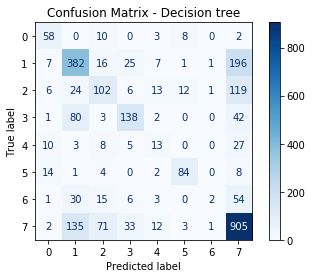

In [32]:
# confusion matrix - Internal Test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [37]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best parameters:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 5}
accuracy: 0.5757354240997513
Model with rank: 1
Mean validation score: 0.576 (std: 0.011)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.576 (std: 0.011)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.576 (std: 0.011)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.576 (std: 0.011)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 30}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [33]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=10, min_samples_leaf= 35, min_samples_split=5)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))


Accuracy 0.5605447184394553
F1-score [0.45320197 0.50209205 0.3184466  0.54579439 0.         0.58291457
 0.         0.68275862]
              precision    recall  f1-score   support

           0       0.38      0.57      0.45        81
           1       0.54      0.47      0.50       635
           2       0.35      0.29      0.32       283
           3       0.54      0.55      0.55       266
           4       0.00      0.00      0.00        66
           5       0.67      0.51      0.58       113
           6       0.00      0.00      0.00       111
           7       0.62      0.77      0.68      1162

    accuracy                           0.56      2717
   macro avg       0.39      0.39      0.39      2717
weighted avg       0.52      0.56      0.53      2717



Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 46   5  17   0   0   5   0   8]
 [  9 300  31  40   0   2   0 253]
 [ 26  28  82  14   0   4   0 129]
 [  0  47   6 146   0   2   0  65]
 [ 11  13  14   2   0   3   0  23]
 [ 10   1  12   4   0  58   0  28]
 [  4  30  14  11   0   1   0  51]
 [ 16 136  56  52   0  11   0 891]]


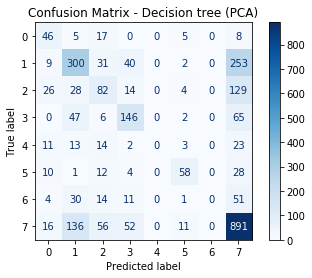

In [36]:
# confusion matrix Decision tree with PCA
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree (PCA)')
print(cm_pca.confusion_matrix)
plt.show()

# 5. KNN


In [37]:
scaler.fit(X_develop)
X_develop_norm =scaler.transform(X_develop)
X_test_norm = scaler.transform(X_test)

### a) Unbalanced - without PCA
#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [40]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop_norm, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
#report(clf.cv_results_)

best parameters:
{'n_neighbors': 14}
accuracy: 0.6505228575910207


#### Train and predict

In [38]:
knn =  KNeighborsClassifier(n_neighbors = 14)
# retrain knn on the whole development set
knn.fit(X_develop_norm, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test_norm)

# display classification report
print(classification_report(y_test, y_pred_knn0))

              precision    recall  f1-score   support

           0       0.54      0.65      0.59        81
           1       0.65      0.58      0.61       635
           2       0.45      0.43      0.44       283
           3       0.66      0.53      0.58       266
           4       0.40      0.06      0.11        66
           5       0.80      0.80      0.80       113
           6       0.27      0.04      0.06       111
           7       0.68      0.83      0.75      1162

    accuracy                           0.64      2717
   macro avg       0.55      0.49      0.49      2717
weighted avg       0.62      0.64      0.62      2717



#### Confusion matrix

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

[[ 53   1  22   0   0   2   0   3]
 [  7 370  28  23   4   3   4 196]
 [ 14  19 123   8   1   2   2 114]
 [  0  66   4 140   0   2   1  53]
 [ 12   3  13   1   4   4   0  29]
 [  5   1  11   2   0  90   0   4]
 [  3  20  14   8   0   2   4  60]
 [  5  90  60  31   1   8   4 963]]


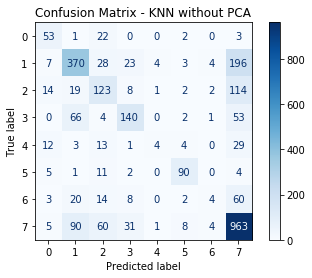

In [39]:
# confusion matrix KNN - Internal test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_knn = plot_confusion_matrix(knn,X_test_norm,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [43]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=2652124)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
#report(clf.cv_results_)

best parameters:
{'n_neighbors': 23}
accuracy: 0.6279606811091553


## 3.1.2 Prediction on Internal test set (KNN - with PCA)
#### Train and predict

In [40]:
knn_pca =  KNeighborsClassifier(n_neighbors = 23)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        81
           1       0.63      0.57      0.60       635
           2       0.42      0.36      0.39       283
           3       0.63      0.52      0.57       266
           4       0.00      0.00      0.00        66
           5       0.84      0.72      0.77       113
           6       0.17      0.01      0.02       111
           7       0.65      0.83      0.73      1162

    accuracy                           0.62      2717
   macro avg       0.48      0.45      0.45      2717
weighted avg       0.59      0.62      0.60      2717



#### Confusion matrix

[[ 49   1  25   0   0   2   0   4]
 [  9 359  21  26   3   0   0 217]
 [ 10  14 103  10   1   2   2 141]
 [  0  60   3 138   0   0   1  64]
 [ 12   7  13   2   0   3   0  29]
 [  2   1  15   2   0  81   0  12]
 [  3  24  15  10   0   1   1  57]
 [  6 102  52  31   2   8   2 959]]


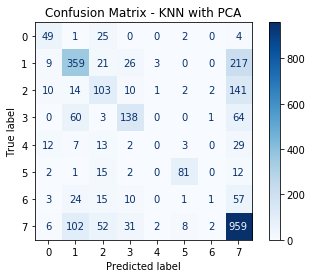

In [41]:
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()